<a href="https://colab.research.google.com/github/ZykinaViktoriya/Python_for_analytics/blob/main/A_B_Python_new_ipynb%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A/B tests с Python




<a id="Libraries"></a>
##  Загрузка библиотек

In [7]:
from scipy.stats import ttest_1samp
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')



In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


<a id="H0"></a>

##Тестирование гипотез

###Гипотеза для коэффициента корелляции

In [9]:
from scipy.stats import pearsonr

data1 = [0.873, 2.817, 0.121, -0.945, -0.055, -1.436, 0.360, -1.478, -1.637, -1.869]

data2 = [0.353, 3.517, 0.125, -7.545, -0.555, -1.536, 3.350, -1.578, -3.537, -1.579]

stat, p = pearsonr(data1, data2)

print('stat=%.3f, p=%.3f' % (stat, p))
if p < 0.05:
    print('Groups are different (reject H0)')
else:
    print('Groups are similar (fail to reject H0)')

stat=0.688, p=0.028
Groups are different (reject H0)


#Поработаем с датасетом c покупками

Метрики
ARPU или Average Revenue Per User - является производным показателем, рассчитывается как средневзвешенное за период агрегации значение Платежи LT/Регистрации. Отображает прибыль, полученную нами с 1 регистрации пользователя, также известен.

ARPPU или Average Revenue Per Paying User - средний платеж платящего пользователя. Рассчитывается как средневзвешенное значение (Платежи LT/Впервые заплативших LT) за период агрегации. Показывает, сколько, в среднем, платит пользователь, ставший платящим, и, зарегистрированный в период агрегации, за всю жизнь.



#Подготовка данных

In [10]:
#Подгружаем данные с гугл диска
from google.colab import drive
drive.mount('/content/drive')


data = pd.read_csv('/content/drive/MyDrive/Учебная/ab_stats.csv')

data.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,revenue,num_purchases,purchase,ab_group,av_site visit
0,0.0,0,0,A,9.040174
1,0.0,0,0,A,4.811628
2,0.0,0,0,A,7.342623
3,0.0,0,0,A,7.744581
4,0.0,0,0,A,10.511814
5,0.0,0,0,A,9.578727
6,0.0,0,0,A,6.162601
7,0.0,0,0,A,11.909452
8,0.0,0,0,A,6.540910
9,0.0,0,0,A,7.990794


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23652 entries, 0 to 23651
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        23652 non-null  float64
 1   num_purchases  23652 non-null  int64  
 2   purchase       23652 non-null  int64  
 3   ab_group       23652 non-null  object 
 4   av_site visit  23652 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 924.0+ KB


In [12]:
data.shape

(23652, 5)

In [13]:
data.describe()

,revenue,num_purchases,purchase,av_site visit
count,23652.000000,23652.000000,23652.000000,23652.000000
mean,0.324689,0.043590,0.020717,7.013112
std,9.557730,1.079403,0.142438,3.154584
min,0.000000,0.000000,0.000000,-12.073486
25%,0.000000,0.000000,0.000000,5.173787
50%,0.000000,0.000000,0.000000,7.007936
75%,0.000000,0.000000,0.000000,8.864119
max,1303.609284,152.000000,1.000000,22.446822


In [14]:
data.isna().sum()

revenue          0
num_purchases    0
purchase         0
ab_group         0
av_site visit    0
dtype: int64

In [15]:
data.ab_group.value_counts()

A    11835
B    11817
Name: ab_group, dtype: int64

In [16]:
data[data['revenue']>0]

,revenue,num_purchases,purchase,ab_group,av_site visit
45,1.885595,1,1,A,7.654627
54,1.002159,1,1,A,6.392489
82,2.990000,1,1,A,8.596604
104,49.990000,1,1,A,8.885633
110,22.093757,4,1,A,8.708759
...,...,...,...,...,...
23426,2.489611,1,1,B,9.015714
23493,74.950000,5,1,B,5.881950
23495,3.667866,1,1,B,7.450014
23584,19.990000,1,1,B,9.813696


Посмотрим на группы отдельно

In [17]:
data[data['ab_group']=='A'].describe()

,revenue,num_purchases,purchase,av_site visit
count,11835.000000,11835.000000,11835.000000,11835.000000
mean,0.404462,0.050697,0.021631,6.974724
std,13.133218,1.467511,0.145481,2.023533
min,0.000000,0.000000,0.000000,-12.073486
25%,0.000000,0.000000,0.000000,5.656155
50%,0.000000,0.000000,0.000000,6.982329
75%,0.000000,0.000000,0.000000,8.345572
max,1303.609284,152.000000,1.000000,17.728836


In [18]:
data[data['ab_group']=='B'].describe()

,revenue,num_purchases,purchase,av_site visit
count,11817.000000,11817.000000,11817.000000,11817.000000
mean,0.244794,0.036473,0.019802,7.051559
std,3.176534,0.418480,0.139325,3.976799
min,0.000000,0.000000,0.000000,-8.286822
25%,0.000000,0.000000,0.000000,4.380984
50%,0.000000,0.000000,0.000000,7.060873
75%,0.000000,0.000000,0.000000,9.768648
max,113.830000,25.000000,1.000000,22.446822


Пока мы еще ничего не посчитали, но уже можно заметить, что максимальный чек в первой группе сильно больше, чем в группе B. Все мы знаем, что среднее очень неустойчиво к выбросам, так что нам необходимо будет это учесть.

#Проверка на нормальность распределения и применение статистических критериев

##Метрика визиты на юзера

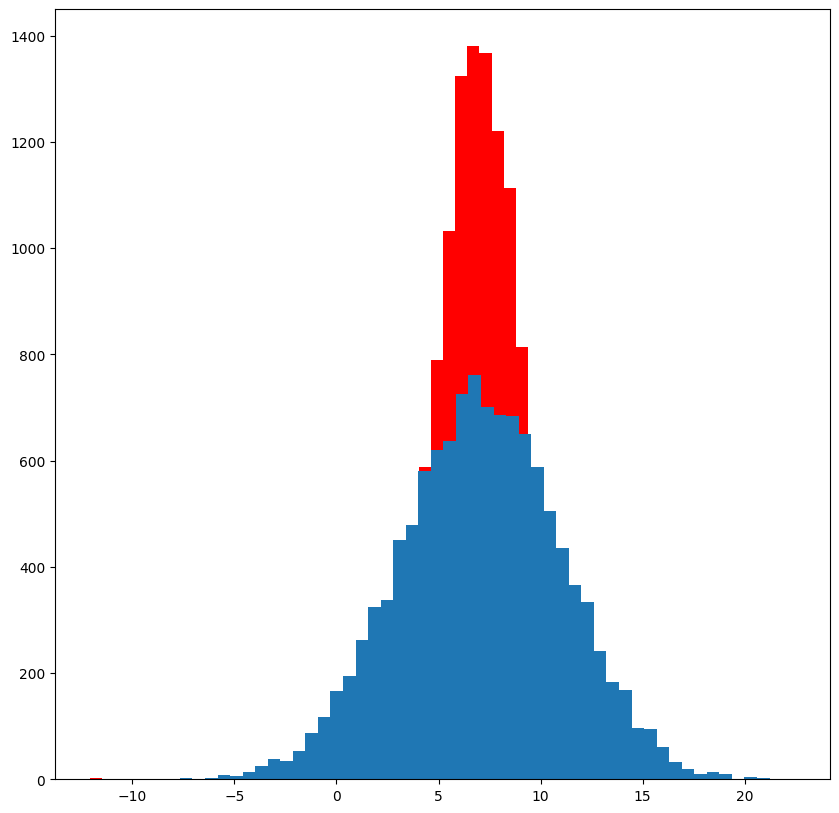

In [19]:
plt.figure(figsize=(10, 10))
control_visit_all = data['av_site visit'][data['ab_group'] == 'A']
test_visit_all =data['av_site visit'][data['ab_group'] == 'B']


plt.hist(control_visit_all, color='r', bins=50)
plt.hist(test_visit_all,  bins=50)


plt.show()

In [20]:
stats.ttest_ind(control_visit_all, test_visit_all, equal_var = False)

NameError: ignored

##Метрика доля юзеров с покупкой

In [ ]:
plt.figure(figsize=(10, 10))
control_visit = data['av_site visit'][(data['ab_group'] == 'A')&(data['purchase'] == 1)]
test_visit =data['av_site visit'][(data['ab_group'] == 'B')&(data['purchase'] == 1)]
plt.hist(test_visit,  bins=20)
plt.hist(control_visit, color='r', bins=20)

plt.show()

In [ ]:
data['purchase'].value_counts()

In [ ]:
k1 = data[data['ab_group']=='A']['purchase'].sum()
k2 = data[data['ab_group']=='B']['purchase'].sum()

In [ ]:
n1 = data[data['ab_group']=='A'].shape[0]
n2 = data[data['ab_group']=='B'].shape[0]

In [ ]:
from statsmodels.stats import proportion

z_score, z_pvalue = proportion.proportions_ztest(np.array([k1, k2]),
                                                   np.array([n1, n2]))
print('Results are ','z_score =%.3f, pvalue = %.3f'%(z_score, z_pvalue))

In [ ]:
if abs(z_pvalue) < 0.05:
    print("We may reject the null hypothesis!")
else:
    print("We have failed to reject the null hypothesis")

Непараметрический Хи-квадрат

In [ ]:
chisq, pvalue, table = proportion.proportions_chisquare(np.array([k1, k2]),
                                                   np.array([n1, n2]))

print('Results are ','chisq =%.3f, pvalue = %.3f'%(chisq, pvalue))

In [ ]:
if abs(pvalue) < 0.05:
    print("We may reject the null hypothesis!")
else:
    print("We have failed to reject the null hypothesis")

#Метрика arpu


 Непараметрический критерий  Манн-Уитни

In [ ]:
data.groupby('ab_group')['revenue'].describe()

In [ ]:
mw_stats = mannwhitneyu(x=data[(data['ab_group'] == 'A')&(data['purchase'] == 1)]['revenue'].values,
                                                  y=data[(data['ab_group'] == 'B')&(data['purchase'] == 1)]['revenue'].values)
mw_stats

##Рассмотрим кейс с рекламной выручкой

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1IGMgJP_XqQwA6h_w1KYG7TQJhS15h4c4',
                                    dest_path='./test.xlsx');

In [ ]:
df = pd.read_excel('test.xlsx')

In [ ]:
df.head(10)

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.isna().sum()

In [ ]:
df.VARIANT_NAME.value_counts()

In [ ]:
#Избавимся от некорретных строк. Посчитаем, сколько типов встречается у каждого пользователя.

v = df.\
    groupby('USER_ID', as_index=False).\
    agg({'VARIANT_NAME': pd.Series.nunique})

In [ ]:
v.head(10)

In [ ]:
more_than_one_types = variants.query('VARIANT_NAME > 1')

In [ ]:
df_new = df[~df.USER_ID.isin(more_than_one_types.USER_ID)].sort_values('USER_ID')

In [ ]:
df_new.shape

In [ ]:
df.shape

In [ ]:
control = df1.query('VARIANT_NAME == "control"')

test = df1.query('VARIANT_NAME == "variant"')

In [ ]:
len(control)

In [ ]:
len(test)

In [ ]:
from scipy.stats import shapiro

In [ ]:
alpha = 0.05

st = shapiro(df.REVENUE)
print('Distribution is {}normal\n'.format( {True:'not ',
False:''}[st[1] < alpha]));

In [ ]:
control.REVENUE.hist(bins = 25, alpha =0.7, label='Control')
test.REVENUE.hist(bins = 25, alpha =0.7, label='Test')
plt.title('Доход на юзера по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

In [ ]:
plt.boxplot([control.REVENUE,test.REVENUE],
            labels=['Контроль','Тест'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

In [ ]:
stats.ttest_ind(control.REVENUE.values, test.REVENUE.values, equal_var = False)

##Расчет мощности


d = (M1 – M2) / S_pooled






## S_pooled =

  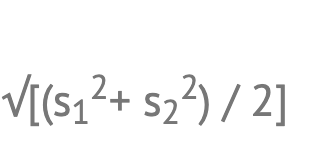

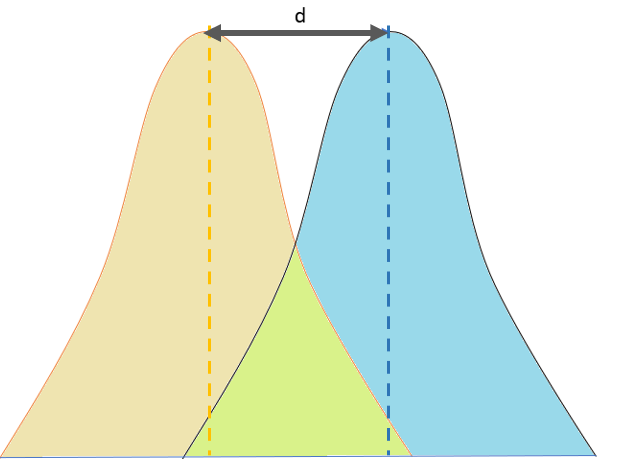

In [ ]:
C_mean = control.REVENUE.values.mean()

T_mean = test.REVENUE.values.mean()


C_std = control.REVENUE.values.std()

T_std = test.REVENUE.values.std()

In [ ]:
print(len(control.REVENUE.values), len(test.REVENUE.values))

In [ ]:
n =  len(control.REVENUE.values)

In [ ]:
##S = np.sqrt((sd_t**2 / n_t) + (sd_c**2 / n_c))

S = np.sqrt((T_std**2 + C_std **2)/ 2)

In [ ]:
ef =float((T_mean-C_mean)/ S)

In [ ]:
# parameters for power analysis

alpha = 0.05

# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=None,
nobs1=n, ratio=1.0, alpha=alpha)

result